In [1]:
import math
from io import BytesIO

import tensorflow as tf
import numpy as np
import PIL.Image
import IPython.display
import matplotlib.pyplot as plt

%matplotlib inline

## Preparing the data

Data comes in CSV format, where the first column is the label and the others represent a pixel intensity value between 0 and 255, in cells 0 to 783 (allowing for 784 cells or 28 x 28).

Going to load the labels and pixel values into a list, then create a numpy array for them both.

In [2]:
import csv

fh = open('./data/train.csv')
reader = csv.reader(fh)

# Skip header line
_ = next(reader)

In [3]:
labels = []
imgs = []

for line in reader:
    label, img = line[0], line[1:]
    
    labels.append(label)
    imgs.append(img)

In [4]:
len(imgs[0])

784

In [5]:
imgs = np.uint8(imgs)

In [6]:
print(imgs.shape)
print(imgs.T.shape)

(42000, 784)
(784, 42000)


In [7]:
def show_digit(a, fmt='png'):
    """To do: optionally show label here."""
    a = a.reshape((28, 28))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [8]:
show_digit(imgs[500])

In [9]:
show_digit(imgs[305])

In [10]:
labels = np.uint8(labels)
labels_sample = labels[:1000]
labels_sample[:5]

array([1, 0, 1, 4, 0], dtype=uint8)

Next, converting the labels into a one hot matrix and normalising the pixel values by dividing by the max.

In [11]:
C = tf.constant(10, name='c')
one_hot_matrix = tf.one_hot(labels, C, axis=0, dtype=tf.uint8)

sess = tf.Session()
labels_one_hot = sess.run(one_hot_matrix)
sess.close()

imgs_norm = imgs / 255.

In [12]:
assert labels_one_hot.shape == (10, len(labels))

In [13]:
dev_set_size = int(len(imgs_norm) * 0.2)

training_imgs_X = imgs_norm.T[:, dev_set_size:]
training_labels_y = labels_one_hot[:, dev_set_size:]

dev_imgs_X = imgs_norm.T[:, :dev_set_size]
dev_labels_y = labels_one_hot[:, :dev_set_size]

In [14]:
print("Training X shape: ", training_imgs_X.shape)
print("Training y shape: ", training_labels_y.shape)

print("Dev X shape: ", dev_imgs_X.shape)
print("Dev y shape: ", dev_labels_y.shape)

Training X shape:  (784, 33600)
Training y shape:  (10, 33600)
Dev X shape:  (784, 8400)
Dev y shape:  (10, 8400)


## Simple Neural Net

Going to build a simple 3-layer NN and see what sort of performance I get. Setting the mini batch size to 64.

In [15]:
num_digits = 10
learning_rate = 0.0001
num_epochs = 1000
print_every = 100
mini_batch_size = 64

In [16]:
def get_random_minibatches(X, Y, mini_batch_size=64, seed=0):
    """Return a list of minibatches in format ([x...], [y...])."""
    np.random.seed(seed)
    m = X.shape[1]
    
    # Create a random list of numbers
    permutations = list(np.random.permutation(m))
    shuffled_X = X[:, permutations]
    shuffled_Y = Y[:, permutations]
    
    num_mini_batches = math.floor(m / mini_batch_size)
    
    for i in range(num_mini_batches):
        start_pos = i * mini_batch_size
        end_pos = start_pos + mini_batch_size
        
        mini_batch_X = shuffled_X[:, start_pos:end_pos]
        mini_batch_Y = shuffled_Y[:, start_pos:end_pos]
        
        yield (mini_batch_X, mini_batch_Y)
        
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, m - mini_batch_size : ]
        mini_batch_Y = shuffled_Y[:, m - mini_batch_size : ]
        yield (mini_batch_X, mini_batch_Y)

Create a simple 3 layer network, by initialising weight vectors and defining simple cost function.

In [21]:
def init_params():
    W1 = tf.get_variable('W1', [256, training_imgs_X.shape[0]], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1', [256, 1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2', [256, 256], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2', [256, 1], initializer=tf.zeros_initializer())
    out = tf.get_variable('out', [10, 256], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    bout = tf.get_variable('bout', [10, 1], initializer=tf.zeros_initializer())
    
    return {
        'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'out': out, 'bout': bout}

In [22]:
def forward_prop(X, params):
    # Hidden fully connected layer with 256 neurons
    Z1 = tf.matmul(params['W1'], X) + params['b1']
    layer_1 = tf.nn.relu(Z1)

    # Hidden fully connected layer with 256 neurons
    Z2 = tf.matmul(params['W2'], layer_1) + params['b2']
    layer_2 = tf.nn.relu(Z2)

    # Output fully connected layer with a neuron for each class
    out_layer = tf.add(tf.matmul(params['out'], layer_2), params['bout'])
    
    return out_layer

In [23]:
def get_cost(out_layer, Y):
    logits = tf.transpose(out_layer)
    labels = tf.transpose(Y)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

Cost at 10 epochs is 0.07842702900547364
Cost at 20 epochs is 0.02384482302325998
Cost at 30 epochs is 0.005488241370933661
Cost at 40 epochs is 0.0008986686833876383
Cost at 50 epochs is 0.00011584080914785542
Cost at 60 epochs is 1.2372904813722532e-05
Cost at 70 epochs is 1.1787713789125827e-06
Cost at 80 epochs is 1.1378082555775425e-07
Cost at 90 epochs is 1.5844897879049202e-08
Cost at 100 epochs is 4.970601140210019e-09


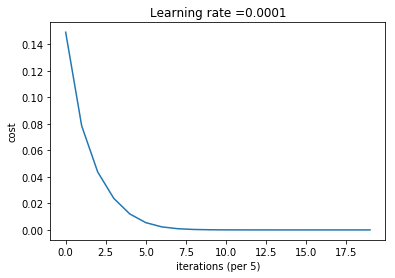

Train Accuracy: 1.0
Test Accuracy: 0.973929


In [38]:
m = training_imgs_X.shape[1]

num_epochs = 100
print_every = 10

tf.reset_default_graph()

with tf.Session() as sess:
    X = tf.placeholder(tf.float32, shape=(training_imgs_X.shape[0], None), name='X')
    Y = tf.placeholder(tf.float32, shape=(10, None), name='Y')
    
    costs = []
    num_mini_batches = m / mini_batch_size
    
    params = init_params()
    
    out_layer = forward_prop(X, params)
    
    cost = get_cost(out_layer, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    sess.run(init)
        
    for epoch in range(1, num_epochs + 1):
        epoch_cost = 0.
        
        minibatches = get_random_minibatches(training_imgs_X, training_labels_y, mini_batch_size)
        
        for X_mini, y_mini in minibatches:
            _, batch_cost = sess.run([optimizer, cost], feed_dict={X: X_mini, Y: y_mini})
            epoch_cost += batch_cost / num_mini_batches
            
        if epoch % print_every == 0:
            print("Cost at {0} epochs is {1}".format(epoch, epoch_cost))
        if epoch % 5 == 0:
            costs.append(epoch_cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 5)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    # Save params
    params = sess.run(params)
    
    correct_prediction = tf.equal(tf.argmax(out_layer), tf.argmax(Y))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    print ("Train Accuracy:", accuracy.eval({X: training_imgs_X, Y: training_labels_y}))
    print ("Test Accuracy:", accuracy.eval({X: dev_imgs_X, Y: dev_labels_y}))

Can't really beat that for train accuracy! Let's see how the model does on the test data.

In [45]:
def predict(X, parameters):  
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    out = tf.convert_to_tensor(parameters["out"])
    bout = tf.convert_to_tensor(parameters["bout"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "out": out,
              "bout": bout}
    
    x = tf.placeholder("float", [784, None])
    
    out_layer = forward_prop(x, params)
    p = tf.argmax(out_layer)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [65]:
fh = open('./data/test.csv')
reader = csv.reader(fh)

# Skip header line
_ = next(reader)

test_imgs = [line for line in reader]

test_imgs = np.uint8(test_imgs)
test_imgs_norm = test_imgs / 255.

In [66]:
predictions = predict(test_imgs_norm.T, params)

In [69]:
show_digit(test_imgs[0]), predictions[0]

(None, 2)

In [70]:
output = open('output.csv', 'w')
output.write(u'ImageId,Label\n')
for count, pred in enumerate(predictions):
    output.write(u'{0},{1}\n'.format(count + 1, pred))
output.close()